In [1]:
from typing import List

from oop_functions.experiment_helper import *
from oop_functions.experiment_runner import ExperimentRunner
from oop_functions.util_functions import summarize_features, print_df
from oop_functions.visualization_util import *
from oop_functions.analytics_cv_util import *
from oop_functions.analytics_utils import *

%matplotlib inline
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from xgboost import XGBClassifier

import itertools


In [2]:
def isin_filter(df: pd.DataFrame, col: str, values: List):
    return df[df[col].isin(values)]

# filtered_on = list(itertools.chain.from_iterable([zip([key]*len(vals), vals) for key, vals in differentiate_confusion_matrix_over.items()]))
# TODO: finish this one
differentiate_confusion_matrix_over = {
    'was_screened': [
        ([0], lambda df: isin_filter(df, 'was_screened', [0])), 
        ([1], lambda df: isin_filter(df, 'was_screened', [1]))
    ], 
    'ovar_histtype': [
        ([2], lambda df: isin_filter(df, 'ovar_histtype', [2])), 
        ([2, 4, 6, 8, 9, 31], lambda df: isin_filter(df, 'ovar_histtype', [2, 4, 6, 8, 9, 31]))
    ]
}


In [3]:
classifiers = {
    # 'LogisticRegression': LogisticRegression(C= 0.25, random_state= 0),
    # 'GaussianNB': GaussianNB(var_smoothing= 1e-09),
    # 'DecisionTreeClassifier': DecisionTreeClassifier(criterion= 'entropy'),
    # 'RandomForestClassifier': RandomForestClassifier(criterion= 'entropy', n_estimators= 200),
    'XGBClassifier': XGBClassifier(eval_metric= 'error', learning_rate= 0.1)
}

experiment_data_helpers: List[ExperimentDataHelper] = [
    # ExperimentDataHelperScreenedOrCancer,
    ExperimentDataHelperScreened,
    ExperimentDataHelperNotScreenedCols,
    ExperimentDataHelperScreenedCols,
    ExperimentDataHelperAll,
    # ExperimentDataHelperSingleLabelScreenedOrCancer,
    # ExperimentDataHelperSingleLabelScreened,
    # ExperimentDataHelperSingleLabelNotScreenedCols,
    # ExperimentDataHelperSingleLabelScreenedCols,
    # ExperimentDataHelperSingleLabelAll
]

In [4]:
experiment_names = []
years = [1]
num_folds=10
for classifier_name, classifier in classifiers.items():
    for year in years:
        for experiment_data_helper_class in experiment_data_helpers:
            label = f'cancer_in_next_{year}_years'
            filesuffix = f'experiment_{experiment_data_helper_class.get_name()}_{classifier_name}_for_{label}_{num_folds}_trials'
            experiment_names.append(filesuffix)

In [5]:
experiment_names

['experiment_participants_screened_XGBClassifier_for_cancer_in_next_1_years_10_trials',
 'experiment_not_screened_cols_XGBClassifier_for_cancer_in_next_1_years_10_trials',
 'experiment_screened_cols_XGBClassifier_for_cancer_in_next_1_years_10_trials',
 'experiment_participants_all_XGBClassifier_for_cancer_in_next_1_years_10_trials']

In [7]:
filesuffix = 'experiment_not_screened_cols_XGBClassifier_for_cancer_in_next_1_years_10_trials'
cv_analytics_util = CvAnalyticsUtil.load_cv_analytics_utils(filesuffix)

In [8]:
threshold = 0.1611

In [9]:
# TODO: create unique PLCO_ID

In [10]:
id_col = 'index'

In [11]:
all_mid_confidence_ids = []
all_high_confidence_ids = []
all_positive_ids = []
id_and_confidence = []
for analytics_util in cv_analytics_util.analytics_utils:
    y_pred, y_prob = analytics_util.get_predictions() 
    X_test_mismatch = analytics_util.data_util.test_df.copy()[[id_col, 'plco_id', 'age', label]]
    X_test_mismatch[f'{label}_pred'] = y_pred
    X_test_mismatch[f'{label}_prob'] = y_prob
    X_test_mismatch = X_test_mismatch.drop_duplicates()
    # X_test_mismatch = X_test_mismatch[X_test_mismatch[label] != X_test_mismatch[f'{label}_pred']]
    id_and_confidence.append(X_test_mismatch)
mid_conf_predictions = pd.concat(id_and_confidence)
X_test_mismatch = mid_conf_predictions
# Mid confidence
X_test_mid_conf = X_test_mismatch[(X_test_mismatch[f'{label}_prob'] > threshold) & (X_test_mismatch[f'{label}_prob'] < 1 - threshold)]
mid_conf_ids = X_test_mid_conf[id_col].to_list()
all_mid_confidence_ids.extend(mid_conf_ids)
mid_conf_predictions = X_test_mid_conf
# High Conf
X_test_high_conf = X_test_mismatch[(X_test_mismatch[f'{label}_prob'] <= threshold) | (X_test_mismatch[f'{label}_prob'] >= 1 - threshold)]
high_conf_ids = X_test_high_conf[id_col].to_list()
all_high_confidence_ids.extend(high_conf_ids)
# Positive Ids
X_test_positive = X_test_mismatch[(X_test_mismatch[f'{label}_prob'] > 0.5)]
positive_ids = X_test_positive[id_col].to_list()
all_positive_ids.extend(positive_ids)

In [12]:
mid_range_filter = lambda df: isin_filter(df, id_col, all_mid_confidence_ids)
high_range_filter = lambda df: isin_filter(df, id_col, all_high_confidence_ids)
positive_range_filter = lambda df: isin_filter(df, id_col, all_positive_ids)

In [13]:
def set_filter_display_report(cv_analytics_util, filter):
    cv_analytics_util.set_filter(filter)
    cv_analytics_util.get_cv_report();
    cv_analytics_util.display_graph()

In [14]:
# cv_analytics_util.update_thresholds(threshold)



Cross-Validation measures:
+--------------------+------------+-------------+------------+-----------+
|                    |       mean |         std |        min |       max |
|--------------------+------------+-------------+------------+-----------|
| precision__class_0 | 0.99947    | 0.000107703 | 0.999227   | 0.999608  |
| recall__class_0    | 0.893796   | 0.00667623  | 0.883073   | 0.904359  |
| f1-score__class_0  | 0.943672   | 0.00370572  | 0.937672   | 0.949513  |
| precision__class_1 | 0.00429538 | 0.000534897 | 0.0037037  | 0.0050598 |
| recall__class_1    | 0.493929   | 0.0535047   | 0.402597   | 0.54902   |
| f1-score__class_1  | 0.00851525 | 0.00105354  | 0.00735078 | 0.0100243 |
| accuracy           | 0.893421   | 0.0066379   | 0.88272    | 0.903917  |
| auc                | 0.82516    | 0.016402    | 0.793601   | 0.842297  |
+--------------------+------------+-------------+------------+-----------+


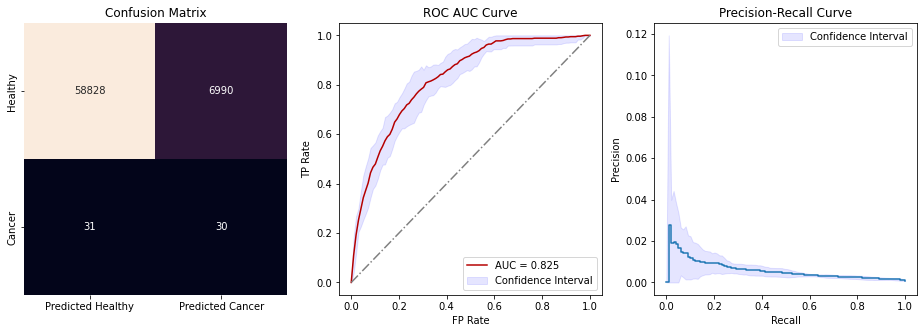



Cross-Validation measures:
+--------------------+------------+-------------+------------+-----------+
|                    |       mean |         std |        min |       max |
|--------------------+------------+-------------+------------+-----------|
| precision__class_0 | 0.998766   | 0.000332528 | 0.998069   | 0.999228  |
| recall__class_0    | 0.722692   | 0.0135598   | 0.705474   | 0.750321  |
| f1-score__class_0  | 0.838527   | 0.00909215  | 0.826858   | 0.856829  |
| precision__class_1 | 0.00380625 | 0.000563119 | 0.00308785 | 0.0044764 |
| recall__class_1    | 0.547412   | 0.0651133   | 0.444444   | 0.621622  |
| f1-score__class_1  | 0.00755858 | 0.0011123   | 0.00614062 | 0.0088853 |
| accuracy           | 0.722342   | 0.0134996   | 0.705213   | 0.749733  |
| auc                | 0.690698   | 0.0430946   | 0.61536    | 0.757645  |
+--------------------+------------+-------------+------------+-----------+


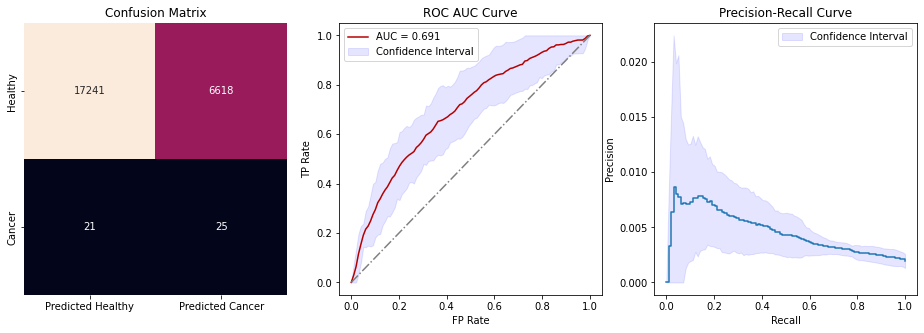



Cross-Validation measures:
+--------------------+-----------+-------------+------------+-----------+
|                    |      mean |         std |        min |       max |
|--------------------+-----------+-------------+------------+-----------|
| precision__class_0 | 0.99976   | 3.71609e-05 | 0.999674   | 0.999805  |
| recall__class_0    | 0.991142  | 0.00199596  | 0.988368   | 0.99362   |
| f1-score__class_0  | 0.995431  | 0.00100291  | 0.99404    | 0.996681  |
| precision__class_1 | 0.0133962 | 0.00482529  | 0.00550964 | 0.0194805 |
| recall__class_1    | 0.322282  | 0.0704849   | 0.2        | 0.428571  |
| f1-score__class_1  | 0.0256557 | 0.00904151  | 0.0107239  | 0.037037  |
| accuracy           | 0.990907  | 0.00198711  | 0.988153   | 0.993384  |
| auc                | 0.82909   | 0.0426504   | 0.75671    | 0.885496  |
+--------------------+-----------+-------------+------------+-----------+


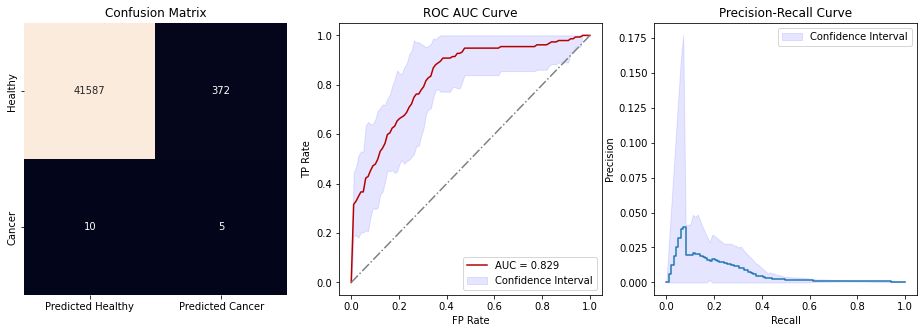

In [15]:
set_filter_display_report(cv_analytics_util, None)
set_filter_display_report(cv_analytics_util, mid_range_filter)
set_filter_display_report(cv_analytics_util, high_range_filter)
# set_filter_display_report(cv_analytics_util, positive_range_filter)

In [16]:
filesuffix = 'experiment_participants_screened_XGBClassifier_for_cancer_in_next_1_years_10_trials'
cv_analytics_util = CvAnalyticsUtil.load_cv_analytics_utils(filesuffix)


In [17]:
threshold = 0.183251076

In [18]:
# cv_analytics_util.update_thresholds(threshold)



Cross-Validation measures:
+--------------------+------------+-------------+------------+-----------+
|                    |       mean |         std |        min |       max |
|--------------------+------------+-------------+------------+-----------|
| precision__class_0 | 0.999416   | 0.000142341 | 0.999192   | 0.999567  |
| recall__class_0    | 0.967238   | 0.00205207  | 0.963802   | 0.969949  |
| f1-score__class_0  | 0.983063   | 0.00108479  | 0.981223   | 0.984394  |
| precision__class_1 | 0.00975279 | 0.00361256  | 0.00434405 | 0.0162602 |
| recall__class_1    | 0.359702   | 0.101877    | 0.227273   | 0.517241  |
| f1-score__class_1  | 0.0189758  | 0.00697197  | 0.00852515 | 0.0314218 |
| accuracy           | 0.966702   | 0.00209601  | 0.963161   | 0.969278  |
| auc                | 0.855888   | 0.0418143   | 0.768209   | 0.928421  |
+--------------------+------------+-------------+------------+-----------+


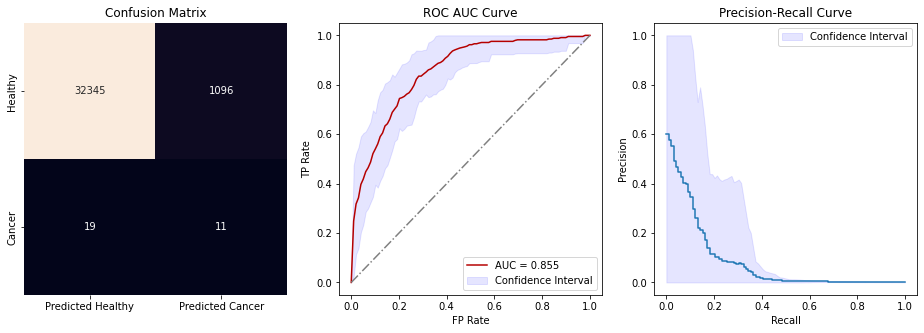



Cross-Validation measures:
+--------------------+------------+-------------+------------+-----------+
|                    |       mean |         std |        min |       max |
|--------------------+------------+-------------+------------+-----------|
| precision__class_0 | 0.998766   | 0.000322977 | 0.998132   | 0.99912   |
| recall__class_0    | 0.921731   | 0.00581258  | 0.91168    | 0.931492  |
| f1-score__class_0  | 0.958695   | 0.0031752   | 0.95325    | 0.963795  |
| precision__class_1 | 0.00863964 | 0.00381556  | 0.00414938 | 0.0151229 |
| recall__class_1    | 0.368604   | 0.119859    | 0.208333   | 0.551724  |
| f1-score__class_1  | 0.0168695  | 0.00739746  | 0.00816327 | 0.0294388 |
| accuracy           | 0.920739   | 0.0058362   | 0.910797   | 0.930148  |
| auc                | 0.766246   | 0.0439297   | 0.707231   | 0.844027  |
+--------------------+------------+-------------+------------+-----------+


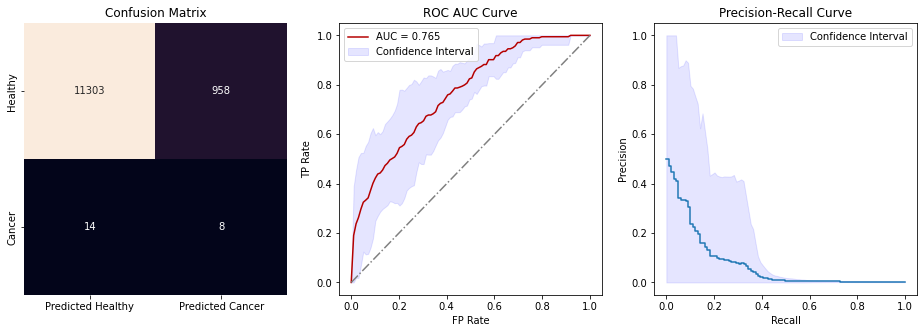



Cross-Validation measures:
+--------------------+-----------+-------------+------------+-----------+
|                    |      mean |         std |        min |       max |
|--------------------+-----------+-------------+------------+-----------|
| precision__class_0 | 0.997813  | 0.000427529 | 0.997093   | 0.998525  |
| recall__class_0    | 0.831994  | 0.0152635   | 0.800888   | 0.851559  |
| f1-score__class_0  | 0.907321  | 0.00906667  | 0.888852   | 0.918724  |
| precision__class_1 | 0.0126029 | 0.00494333  | 0.00645161 | 0.0203785 |
| recall__class_1    | 0.52247   | 0.135528    | 0.357143   | 0.777778  |
| f1-score__class_1  | 0.0245956 | 0.00956724  | 0.0126783  | 0.0397163 |
| accuracy           | 0.83085   | 0.0149655   | 0.800765   | 0.849852  |
| auc                | 0.781234  | 0.0649601   | 0.678945   | 0.893927  |
+--------------------+-----------+-------------+------------+-----------+


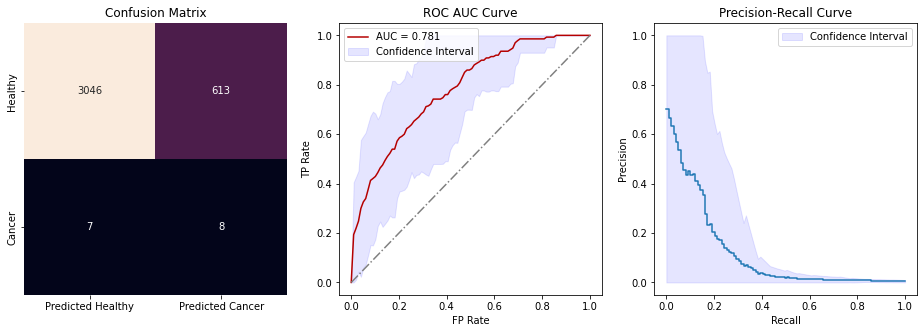

In [19]:
set_filter_display_report(cv_analytics_util, None)
set_filter_display_report(cv_analytics_util, mid_range_filter)
# set_filter_display_report(cv_analytics_util, high_range_filter)
set_filter_display_report(cv_analytics_util, positive_range_filter)

In [20]:
# filesuffix = 'experiment_participants_all_XGBClassifier_for_cancer_in_next_1_years_10_trials'
# cv_analytics_util = CvAnalyticsUtil.load_cv_analytics_utils(filesuffix)


In [21]:
# set_filter_display_report(cv_analytics_util, None)
# set_filter_display_report(cv_analytics_util, mid_range_filter)
# set_filter_display_report(cv_analytics_util, high_range_filter)
# set_filter_display_report(cv_analytics_util, positive_range_filter)

In [22]:
# thresholds = []
# for analytics_util in cv_analytics_util.analytics_utils:
#     thresholds.append(analytics_util.get_report_generation_util().get_roc_threshold())

In [23]:
full_df = []
for analytics_util in cv_analytics_util.analytics_utils:
    full_df.append(analytics_util.data_util.test_df)
full_df = pd.concat(full_df)
full_df = full_df[full_df[id_col].isin(all_mid_confidence_ids)].drop_duplicates()

In [24]:
# for analytics_util in cv_analytics_util.analytics_utils:
#     # analytics_util.data_util.test_df = full_df
#     analytics_util.data_util.test_df = analytics_util.data_util.test_df[analytics_util.data_util.test_df[id_col].isin(all_mid_confidence_ids)]
#     print(len(analytics_util.data_util.test_df))

In [25]:
# TODO: compare the confidences
id_and_confidence = []
for analytics_util in cv_analytics_util.analytics_utils:
    y_pred, y_prob = analytics_util.get_predictions_filtered(mid_range_filter) 
    X_test_mismatch = mid_range_filter(analytics_util.data_util.test_df).copy()[[id_col, 'plco_id', label]]
    # X_test_mismatch = mid_range_filter(analytics_util.data_util.test_df).copy()
    X_test_mismatch[f'{label}_pred'] = y_pred
    X_test_mismatch[f'{label}_prob'] = y_prob
    X_test_mismatch = X_test_mismatch.drop_duplicates()
    id_and_confidence.append(X_test_mismatch)
    mid_conf_ids = X_test_mismatch[id_col].to_list()
mid_conf_predictions_2 = pd.concat(id_and_confidence)
confidence_comp = mid_conf_predictions_2.merge(mid_conf_predictions, on=[id_col, 'plco_id', label], how='left', suffixes=['_2', '_1']).dropna()

In [26]:
fn_on_first_try = confidence_comp[(confidence_comp['cancer_in_next_1_years'] == 1) & (confidence_comp['cancer_in_next_1_years_pred_1'] == 0)]
fn_on_second_try = confidence_comp[(confidence_comp['cancer_in_next_1_years'] == 1) & (confidence_comp['cancer_in_next_1_years_pred_2'] == 0)]

In [27]:
fn_on_second_try

,index,plco_id,cancer_in_next_1_years,cancer_in_next_1_years_pred_2,cancer_in_next_1_years_prob_2,age,cancer_in_next_1_years_pred_1,cancer_in_next_1_years_prob_1
1166,5746.0,A-038636-9,1.0,0,0.185735,65.0,1,0.619167
2082,10605.0,A-059741-1,1.0,0,0.136299,65.0,0,0.299150
2438,12555.0,A-067814-6,1.0,0,0.233112,65.0,0,0.232949
2497,12910.0,A-069164-3,1.0,0,0.010508,75.0,1,0.608669
3009,15172.0,A-077660-1,1.0,0,0.030597,70.0,1,0.709999
...,...,...,...,...,...,...,...,...
121502,651317.0,Z-133882-2,1.0,0,0.168239,75.0,0,0.487136
121695,652492.0,Z-138157-4,1.0,0,0.159991,65.0,0,0.463212
121788,653051.0,Z-139804-0,1.0,0,0.452461,60.0,0,0.381170
121964,654404.0,Z-146095-6,1.0,0,0.466892,75.0,0,0.208109


In [28]:
len(fn_on_first_try[fn_on_first_try['cancer_in_next_1_years_prob_2'] < fn_on_first_try['cancer_in_next_1_years_prob_1']])

64

In [29]:
len(fn_on_first_try[fn_on_first_try['cancer_in_next_1_years_prob_2'] < fn_on_first_try['cancer_in_next_1_years_prob_1'] + 0.1])

76

In [30]:
print_df(fn_on_first_try)

+--------+---------+------------+--------------------------+---------------------------------+---------------------------------+-------+---------------------------------+---------------------------------+
|        |   index | plco_id    |   cancer_in_next_1_years |   cancer_in_next_1_years_pred_2 |   cancer_in_next_1_years_prob_2 |   age |   cancer_in_next_1_years_pred_1 |   cancer_in_next_1_years_prob_1 |
|--------+---------+------------+--------------------------+---------------------------------+---------------------------------+-------+---------------------------------+---------------------------------|
|    182 |     892 | A-008936-9 |                        1 |                               1 |                      0.986036   |    70 |                               0 |                        0.450966 |
|   2082 |   10605 | A-059741-1 |                        1 |                               0 |                      0.136299   |    65 |                               0 |          

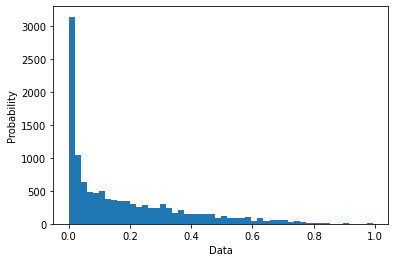

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(X_test_mismatch[f'{label}_prob'], density=False, bins=50)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');



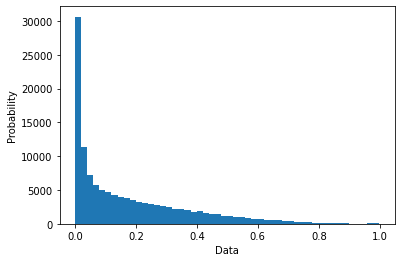

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(mid_conf_predictions_2[f'{label}_prob'], density=False, bins=50)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');



In [33]:
# for filesuffix in experiment_names:
#     print(filesuffix)
#     load_cv_analytics_util_see_stats(filesuffix)